# Решающее дерево

## Подключение библиотек

In [ ]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## 1. Данные

### Разделение данных на тренировочные и тестовые

In [ ]:
features_train = []
prices = []

with open('./dataset/preprocessed_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    feature_titles = [key for key in reader.fieldnames if key != 'Survived']
    
    for row in reader:
        sale_price = float(row['Survived'])
        feature_values = []
        for feature in feature_titles:
            value = row[feature]
            feature_values.append(float(value))
        
        features_train.append(feature_values)
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices)

x_train, x_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
scaler = StandardScaler()

for i, feature in enumerate(feature_titles):
    if feature in numerical_features:
        x_train[:, i] = scaler.fit_transform(x_train[:, i].reshape(-1, 1)).flatten()
        x_test[:, i] = scaler.transform(x_test[:, i].reshape(-1, 1)).flatten()

### Визуализация данных

In [ ]:
table_data = []
headers = ["Index"] + feature_titles + ["Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data[:20], headers=headers, tablefmt="grid", numalign="left"))

+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| Index   | Pclass   | Sex   | Age       | SibSp     | Parch     | Fare       | Embarked   | Survived   |
+=========+==========+=======+===========+===========+===========+============+============+============+
| 0       | 1        | 0     | -1.85798  | -0.474161 | 1.99885   | 0.980998   | 2          | 1          |
+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| 1       | 3        | 0     | -0.278303 | -0.474161 | -0.479327 | -0.469634  | 2          | 0          |
+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| 2       | 3        | 1     | -2.08365  | 0.348687  | 0.759763  | -0.406136  | 2          | 1          |
+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| 3       | 2        | 0     | 0.549149  | 0.3

### Оставляем только два признака (Age, Fare)


In [ ]:
x_train = x_train[:, [2, 5]]
x_test = x_test[:, [2, 5]]

### Визуализируем оставшиеся данные

In [ ]:
table_data = []
headers = ["Index", "Age", "Fare", "Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data[:20], headers=headers, tablefmt="grid", numalign="left"))

+---------+-----------+------------+------------+
| Index   | Age       | Fare       | Survived   |
+=========+===========+============+============+
| 0       | -1.85798  | 0.980998   | 1          |
+---------+-----------+------------+------------+
| 1       | -0.278303 | -0.469634  | 0          |
+---------+-----------+------------+------------+
| 2       | -2.08365  | -0.406136  | 1          |
+---------+-----------+------------+------------+
| 3       | 0.549149  | -0.0802318 | 0          |
+---------+-----------+------------+------------+
| 4       | 1.07571   | -0.109651  | 0          |
+---------+-----------+------------+------------+
| 5       | 0.699595  | 2.38538    | 0          |
+---------+-----------+------------+------------+
| 6       | 0.173034  | -0.109651  | 1          |
+---------+-----------+------------+------------+
| 7       | 0.0225886 | -0.466609  | 0          |
+---------+-----------+------------+------------+
| 8       | -0.804863 | -0.461706  | 0          |


## 2. Построение модели

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None
        
    def fit(self, X, Y) -> None:
        Y = np.array(Y, dtype=int)
        self.tree = self._build_tree(X, Y)
    
    def _build_tree(self, X, Y, depth=0):
        n_labels = len(np.unique(Y))
        if depth >= self.max_depth or n_labels == 1:
            leaf_value = np.bincount(Y).argmax()
            return {'value': leaf_value}
        
        feature_idx, threshold = self._best_split(X, Y)
        if feature_idx is None or threshold is None:
            leaf_value = np.bincount(Y).argmax()
            return {'value': leaf_value}
        
        left_branch = X[:, feature_idx] <= threshold
        right_branch = X[:, feature_idx] > threshold
        
        left_tree = self._build_tree(X[left_branch], Y[left_branch], depth + 1)
        right_tree = self._build_tree(X[right_branch], Y[right_branch], depth + 1)
        
        return {
            'feature_index': feature_idx,
            'threshold': threshold,
            'left': left_tree,
            'right': right_tree
        }
        
    def _best_split(self, X, Y):
        n_features = X.shape[1]
        feature_indices = range(n_features) if n_features <= 2 else np.random.choice(n_features, size=int(np.sqrt(n_features)), replace=False)
        
        best_feature, best_threshold, lowest_loss = None, None, float('inf')
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_branch = X[:, feature_idx] <= threshold
                right_branch = X[:, feature_idx] > threshold
                if len(Y[right_branch]) == 0:
                    continue  
                
                loss = self._weighted_impurity(Y, Y[left_branch], Y[right_branch])
                if loss < lowest_loss:
                    lowest_loss = loss
                    best_feature = feature_idx
                    best_threshold = threshold
                    
        return best_feature, best_threshold              
                
    def _gini_impurity(self, Y):
        probabilities = np.bincount(Y) / len(Y)
        return np.sum([p * (1 - p) for p in probabilities])
    
    def _weighted_impurity(self, parent, left, right):
        n = len(parent)
        n_left = len(left) 
        n_right = len(right) 
        
        total_impurity = (n_left / n) * self._gini_impurity(left) + \
                        (n_right / n) * self._gini_impurity(right)          
        return total_impurity

    def predict(self, X):
        return np.array([self._predict_sample(self.tree, sample) for sample in X])
    
    def _predict_sample(self, node, x):
        if 'value' in node:
            return node['value']
        if x[node['feature_index']] <= node['threshold']:
            return self._predict_sample(node['left'], x)
        if x[node['feature_index']] > node['threshold']:
            return self._predict_sample(node['right'], x)
        
    def score(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)

## 3. Тренировка 

In [ ]:
model = DecisionTree(max_depth=20)
model.fit(x_train, y_train)

## 4. Оценка качества модели

In [ ]:
print(f"Accuracy on training data: {model.score(x_train, y_train) * 100:.2f}%")
print(f"Accuracy on test data: {model.score(x_test, y_test) * 100:.2f}%")

Accuracy on training data: 96.79%
Accuracy on test data: 65.30%


## 5. Визуализация модели

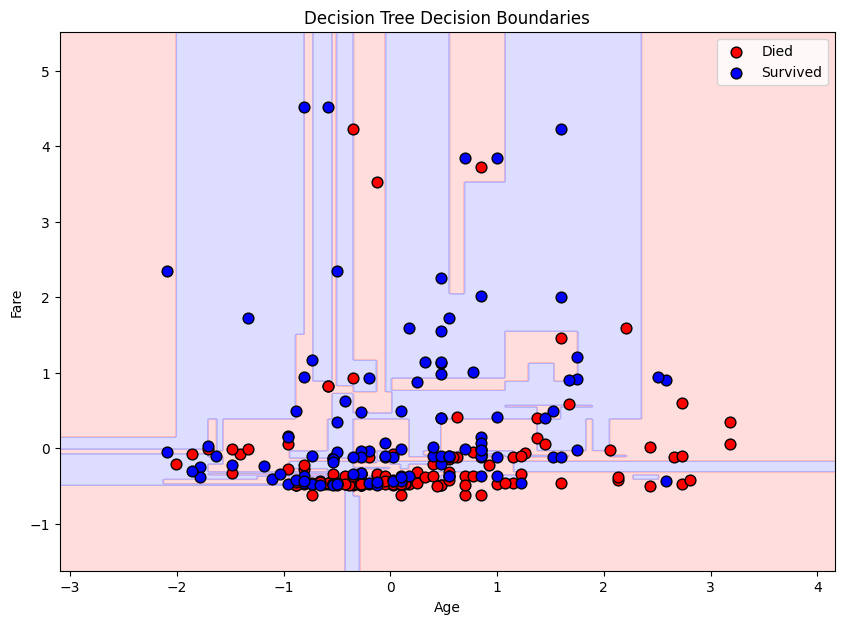

In [ ]:
plt.figure(figsize=(10, 7))

x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF']) 
cmap_bold = ListedColormap(['#FF0000', '#0000FF']) 

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

x_died = x_test[y_test == 0]  
x_survived = x_test[y_test == 1]  

plt.scatter(x_died[:, 0], x_died[:, 1], c='red', edgecolor='k', s=60, label='Died')
plt.scatter(x_survived[:, 0], x_survived[:, 1], c='blue', edgecolor='k', s=60, label='Survived')
plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title("Decision Tree Decision Boundaries")
plt.show()